In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from helper import *

tr = pd.read_csv("training.csv")
te = pd.read_csv("testing.csv")
runs = pd.concat([tr,te]).drop(["level_0"],axis=1)

runs2 = pd.read_csv("total_3.csv")
runs2.rename(columns={"Pla":"finishing_position"}, inplace=True)

feats = ['actual_weight','declared_horse_weight','win_odds','jockey_ave_rank','trainer_ave_rank',
'recent_ave_rank','race_distance']

In [36]:
# Data length
print("Len of runs: {}".format(len(runs)))
print("Len of runs2: {}".format(len(runs2)))

Len of runs: 29364
Len of runs2: 79447


In [37]:
# Race size:
print("Race avg size of runs: {}".format(float(len(runs))/len(np.unique(runs["race_id"]))))
print("Race avg size of runs2: {}".format(float(len(runs2))/len(np.unique(runs2["race_id"]))))

Race avg size of runs: 12.405576679340937
Race avg size of runs2: 12.515280403276623


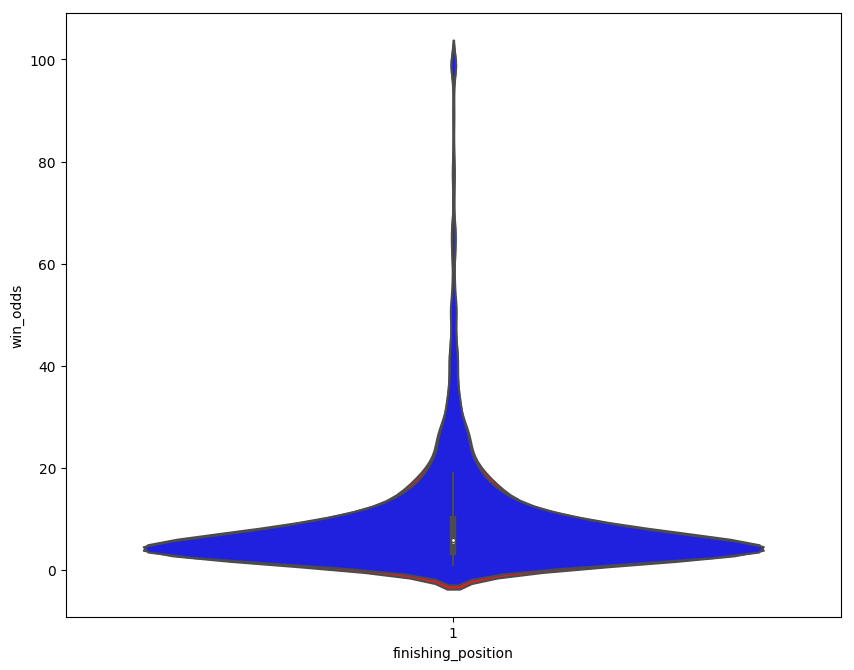

In [38]:
# Does lowest odds correspond to place
plt.figure(figsize=(10,8), dpi=100)
sns.violinplot(x=runs.loc[runs.finishing_position==1]["finishing_position"], y=runs.loc[runs.finishing_position==1]["win_odds"], color="r")
sns.violinplot(x=runs2.loc[runs2.finishing_position==1]["finishing_position"], y=runs2.loc[runs2.finishing_position==1]["win_odds"], color="b")

In [43]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

kfold = KFold(n_splits = 5)

for training, testing in getCrossVal(runs, 5):
    model = GaussianNB()
    X_train = training[feats]
    y_train = training
    X_test = testing[feats]
    y_test = testing

    print(np.mean(cross_val_score(model,X_train,y_train['HorseWin'],cv = kfold,scoring = 'f1')))
print()
for training, testing in getCrossVal(runs2, 5):
    model = GaussianNB()
    X_train = training[feats]
    y_train = training
    X_test = testing[feats]
    y_test = testing

    print(np.mean(cross_val_score(model,X_train,y_train['HorseWin'],cv = kfold,scoring = 'f1')))

0.19642636609801412
0.21011587975013252
0.21214533962588306
0.211925359436202
0.2076692355158089

0.09120134343645851
0.09847803039841199
0.07913060885602415
0.09514601689547748
0.0974855267363253


In [78]:
def crossVal(dat, feat, target, model, n_folds=4):
    
    dat = dat.copy()
    race_ids = np.unique(dat["race_id"])
    cv = KFold(n_splits=n_folds, shuffle=True)
    
    scores = []
    count = 1
    for train_race_id, test_race_id in cv.split(race_ids):
        print("CV {}/{}".format(count, n_folds))
        train_races = race_ids[train_race_id]
        test_races = race_ids[test_race_id]
        
        X_train = dat.loc[dat["race_id"].isin(train_races)][feat]
        y_train = dat.loc[dat["race_id"].isin(train_races)][target]
        X_test = dat.loc[dat["race_id"].isin(test_races)][feat]
        y_test = dat.loc[dat["race_id"].isin(test_races)][target]
        
        model.fit(X_train, y_train)
        
        testDat = dat.loc[dat["race_id"].isin(test_races)]
        testGroups = [len(testDat.loc[testDat["race_id"]==race_id]) for race_id in np.unique(testDat["race_id"])]
        scores.append(winnerEval(model, X_test, y_test, target, testGroups))
        count += 1
        
    meanScore = np.mean(scores)
    stdScore = np.std(scores)
    
    print("Mean score: {:.3f} +/- {:.3f}".format(meanScore, stdScore))
    
    return meanScore, stdScore

# Create our evaluate function
def winnerEval(model, x_test, y_test, target, race_sizes):
    # convert preds into an actual win choice
    winPreds = model.predict_proba(x_test)[:, 1]
    winCount = 0
    temp = 0 
    for i, s in enumerate(race_sizes):
        low_index = temp
        high_index = temp + s
        
        racePreds = winPreds[low_index:high_index]
        raceVals = y_test[low_index:high_index]
        
        predWinner = np.argmax(racePreds, axis=0)
        actWinner = np.argmax(raceVals, axis=0)
        if sum(raceVals)!=1:
            print("EDED")

        if predWinner == actWinner:
            winCount += 1
            
        temp += s
        
    return winCount/float(len(race_sizes))

In [81]:
crossVal(runs, feats, "HorseWin", GaussianNB())
crossVal(runs2, feats, "HorseWin", GaussianNB())

CV 1/4
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
CV 2/4
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
CV 3/4
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
CV 4/4
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
EDED
Mean score: 0.236 +/- 0.011
CV 1/4
EDED
EDED
CV 2/4
EDED
EDED
EDED
CV 3/4
EDED
EDED
EDED
CV 4/4
EDED
EDED
EDED
EDED
Mean score: 0.201 +/- 0.005


(0.2010081915563957, 0.004608928430475039)